In [8]:
import jax
from jax.config import config
import jax.numpy as np
config.update("jax_enable_x64", True)

from DMA_MR_ss import *
import matplotlib.pyplot as plt

from opyrability import implicit_map

In [9]:
theta = np.linspace(0, 2 * np.pi, 400)
phi = np.pi / 4
a, b= 0.15, 1
h, k = 22.4 , 39.4
y1 = h +  (a * np.cos(theta) * np.cos(phi) - b * np.sin(theta) * np.sin(phi))  
y2 = k +  (b * np.sin(theta) * np.cos(phi) + a * np.cos(theta) * np.cos(phi))

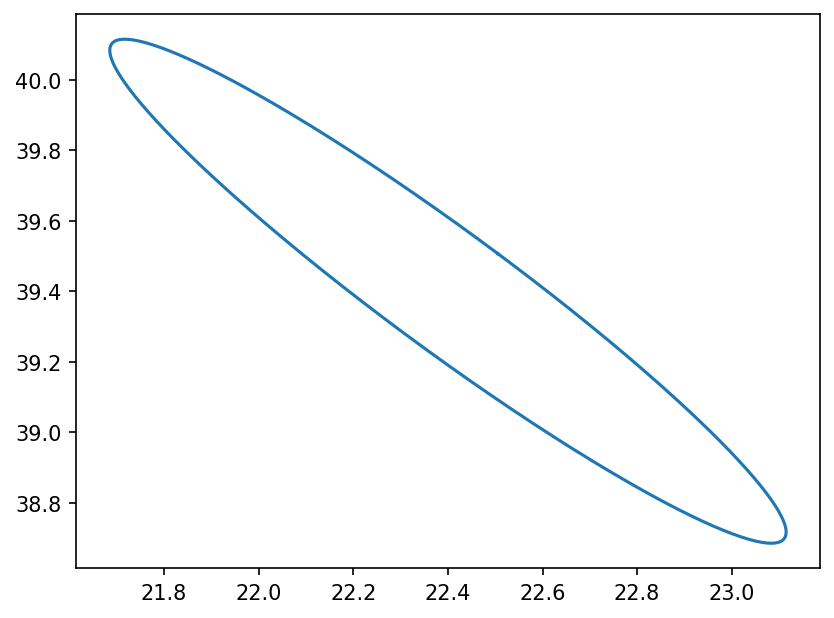

In [10]:
AIS_PTS=np.array([y1,y2]).T
plt.plot(AIS_PTS[:,0], AIS_PTS[:,1])

In [11]:
output_init = np.array([480.00, 600.00])

In [12]:
AIS, AOS, AIS_poly, AOS_poly = implicit_map(dma_mr_uncertain_flows,  
                                        output_init,
                                        continuation='odeint',
                                        domain_points=AIS_PTS,
                                        direction = 'inverse')

Inverse Mapping Selected.
The given domain is recognized as Desired Output Set (DOS).
The result of this mapping is an Desired Input Set(DIS)
Selected odeint


100%|██████████| 400/400 [07:25<00:00,  1.11s/it]


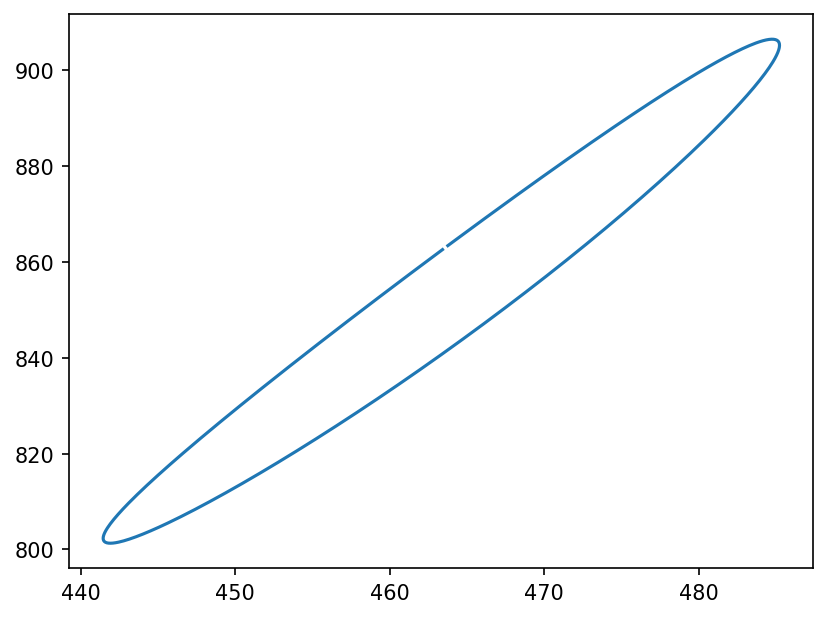

In [13]:
AOS_PTS = AOS.reshape(-1,2)
plt.figure()
plt.plot(AOS_PTS[1:,0], AOS_PTS[1:,1])


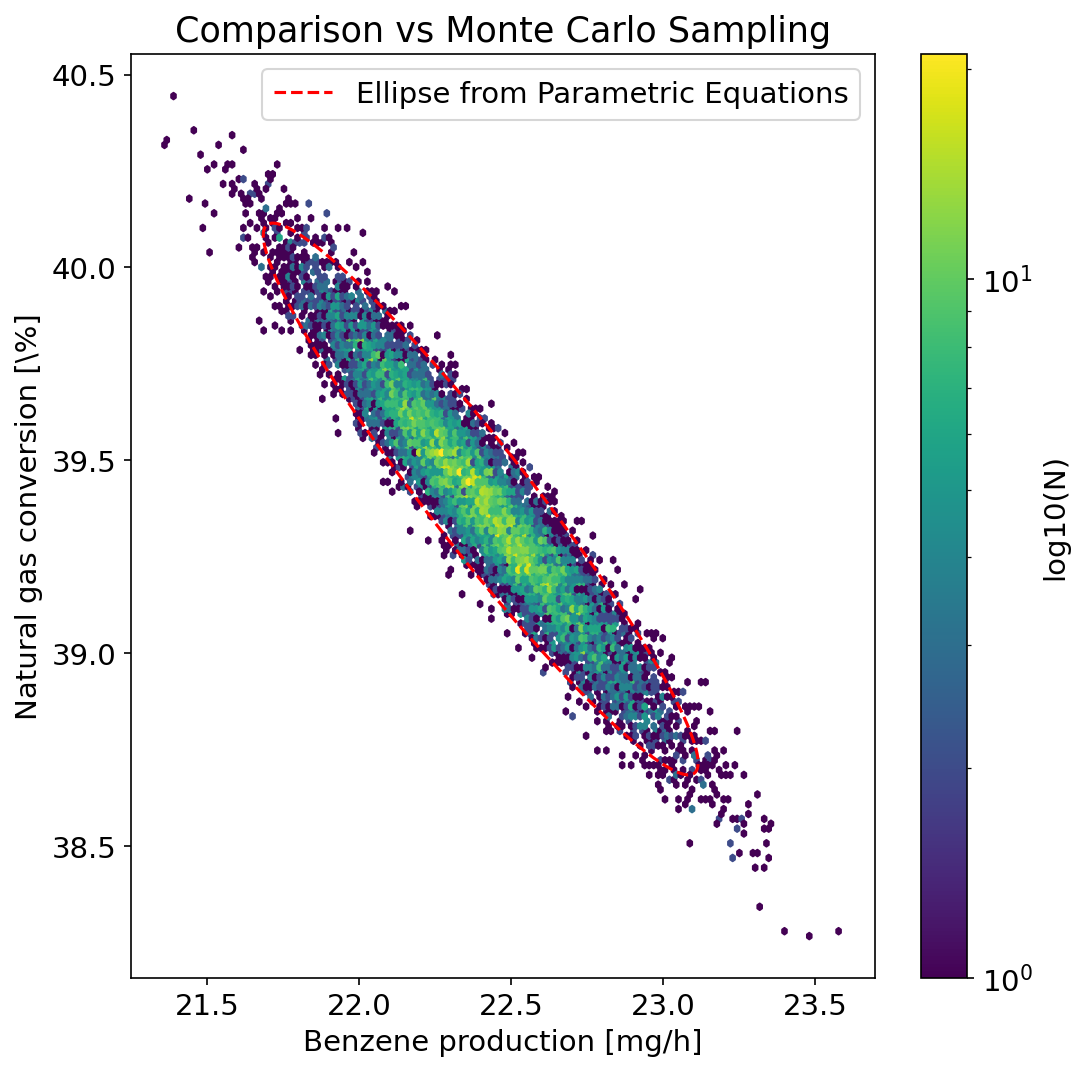

In [57]:
from jax import random
# Set the key for random number generation
key = random.PRNGKey(0)

# Number of simulation points and center of ellipse.
num_simulations = 10000
a, b= 0.15, 1




# Scaling factor for 95% confidence interval in 2D
from scipy.stats import chi2
alpha = 0.95 # Confidence
dof   = 2    # Degrees of freedom
# scaling factor, 2.4477 for 95%
scaling_factor  = np.sqrt(chi2.ppf(alpha, dof))  # take the square root. :)



# Adjust the a and b values - here a and b are adjusted to be able to build the covariance matrix to draw the multivariate normal distribution that will be within 95% of the cloud of points.
a_adjusted = a / scaling_factor
b_adjusted = b / scaling_factor


# Constructing the covariance matrix using a, b, and rotation matrix

covariance_matrix_initial = np.array([[a_adjusted**2,  0], 
                                      [0,              b_adjusted**2]])


rotation_matrix = np.array([[np.cos(phi), -np.sin(phi)], 
                            [np.sin(phi), np.cos(phi)]])


covariance_matrix_constructed = rotation_matrix @ covariance_matrix_initial @ rotation_matrix.T


# Plotting the ellipses with constructed covariance matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(y1, y2, 'r--', label='Ellipse from Parametric Equations')
# Monte Carlo Sampling simulations
mean = np.array([h, k])
samples = random.multivariate_normal(key, mean, covariance_matrix_constructed, (num_simulations,))

hb=ax.hexbin(samples[:, 0], samples[:, 1], gridsize=150, cmap='viridis', bins='log')
fig.colorbar(hb, ax=ax, label='log10(N)')
ax.set_xlabel('Benzene production [mg/h]')
ax.set_ylabel('Natural gas conversion [\%]')
ax.set_title('Comparison vs Monte Carlo Sampling')
ax.legend()
plt.show()

In [58]:
from opyrability import nlp_based_approach
from DMA_MR_ss import dma_mr_uncertain_flows_check
from IPython.display import display, clear_output
import time  # Just for demonstration purposes
benzene_samples = samples[:, 0]
ch4_samples = samples[:, 1]


# Calculating Ca and Cb for each Monte Carlo simulation
v0_values = []
v_He_values = []
DOS_resolution = [1, 1]
u0 = output_init
lb = np.array([300, 300])
ub = np.array([1000, 1000])
for i in range(num_simulations):
    print(i)
    benzene = benzene_samples[i]
    ch4 = ch4_samples[i]
    
    DOS_bounds = np.array([[benzene, benzene],
                          [ch4, ch4]])

    fDIS, fDOS, conv = nlp_based_approach(dma_mr_uncertain_flows_check,
                                              DOS_bounds, 
                                              DOS_resolution,
                                              u0, 
                                              lb,ub,
                                              method='ipopt', 
                                              plot=False,
                                              ad=True,
                                              warmstart=True)
    time.sleep(1)  # Delay for 1 second so you can observe the change
    clear_output(wait=True)  # Clear the output
    
    v0_values.append(fDIS[:,0])
    v_He_values.append(fDIS[:,1])



9999
 You have selected automatic differentiation as a method for obtaining higher-order data (Jacobians/Hessian),
 Make sure your process model is JAX-compatible implementation-wise.


100%|██████████| 1/1 [00:00<00:00,  1.34it/s]


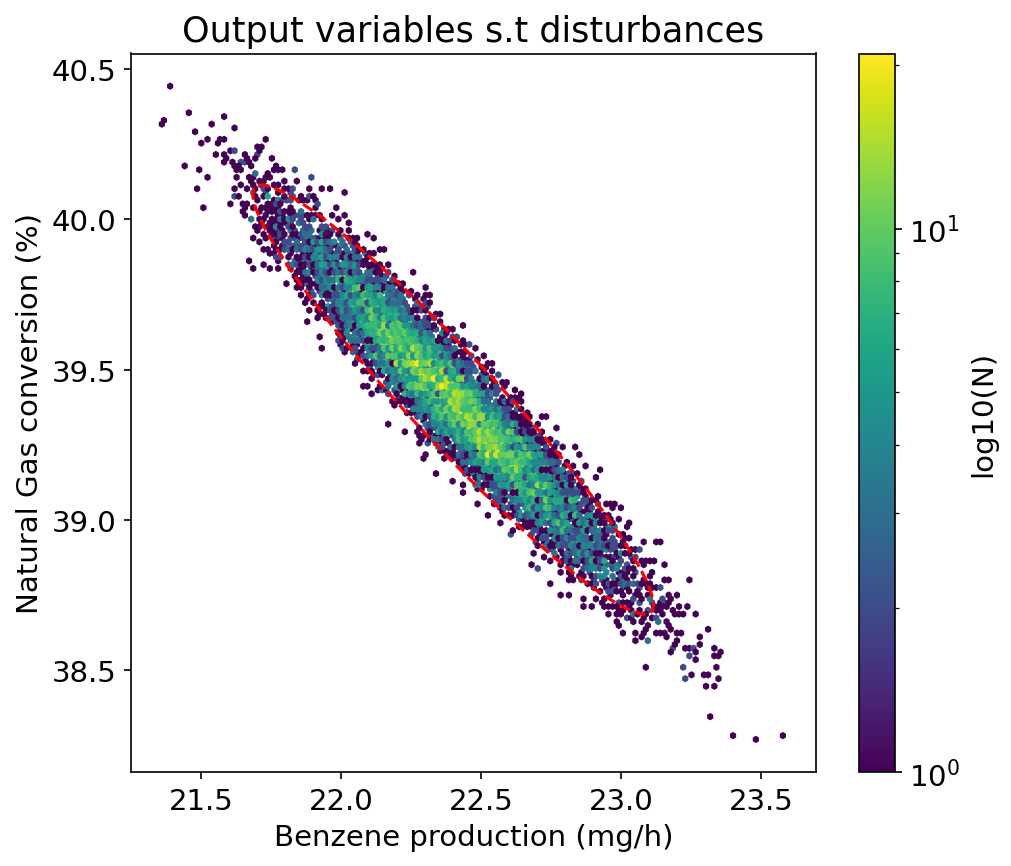

In [59]:
# Adjusting global font size
plt.rcParams.update({'font.size': 14})

fig, ax1 = plt.subplots(figsize=(7,6))
hb = ax1.hexbin(benzene_samples, ch4_samples, gridsize=150, cmap='viridis', bins='log')
fig.colorbar(hb, ax=ax1, label='log10(N)')
ax1.plot(y1, y2, 'r--', label='Disturbance region described by closed-path')
ax1.set_title('Output variables s.t disturbances')
ax1.set_xlabel('Benzene production (mg/h)')
ax1.set_ylabel('Natural Gas conversion (%)')
fig.tight_layout()
plt.show()


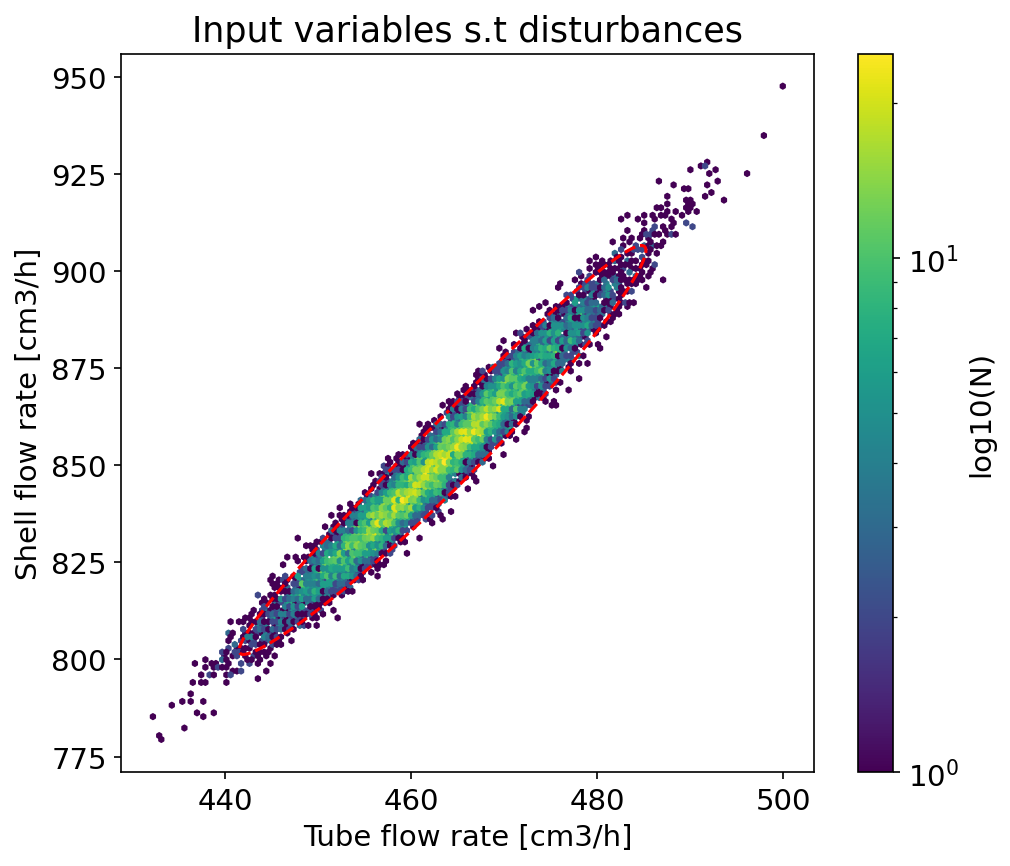

In [60]:
fig, ax2 = plt.subplots(figsize=(7,6))
hb = ax2.hexbin(v0_values, v_He_values, gridsize=150, cmap='viridis', bins='log')
fig.colorbar(hb, ax=ax2, label='log10(N)')
ax2.plot(AOS_PTS[1:,0], AOS_PTS[1:,1],'r--', label='opyrability')
ax2.set_title('Input variables s.t disturbances')
ax2.set_xlabel('Tube flow rate [cm3/h]')
ax2.set_ylabel('Shell flow rate [cm3/h]')
fig.tight_layout()
plt.show()


In [ ]:
print(v_He_values)
print(v0_values)

In [64]:
import numpy as npp
v_He_hexbin = npp.array(v_He_values)
v0_hexbin = npp.array(v0_values)
AOS_PTS_hexbin = npp.array(AOS_PTS)

In [70]:
npp.savez('montecarlo2.npz', v_He_hexbin, v0_hexbin, AOS_PTS_hexbin)

In [73]:
points =  np.array([v0_values, v_He_values]).reshape(10000,2)

points.shape

(10000, 2)

In [80]:
AOS_PTS.shape

(400, 2)

In [78]:
import matplotlib.path as mpath

path = mpath.Path(AOS_PTS)

inside_points = path.contains_points(points)

points_in =  np.sum(inside_points)
points_out = len(points) - points_in

print('there are', points_in, 'points within the ellipse')
print('there are', points_out, 'points outside the ellipse')

there are 0 points within the ellipse
there are 10000 points outside the ellipse


In [81]:
print(points_in/num_simulations * 100, '%')

0.0 %


In [82]:
eigenvalues = ((np.linalg.eig(covariance_matrix_constructed))[0])

eigenvalues = np.sqrt(eigenvalues.real*(scaling_factor**2))


print(eigenvalues)

[1.   0.15]
